In [21]:
import torchvision
import torchvision.transforms as transforms
import torch
import numpy as np
import pickle as pkl
import ipdb
import skimage
from skimage.measure import block_reduce
import torch.optim as optim

from IPython.display import Audio

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import librosa
def cqt_specgram(audio, n_bins, bins_per_octave, hop_length, sr, fmin, filter_scale):
    '''
    :param audio:
    :param sr:
    :return: shape = (n_bins, t)
    '''
    c = librosa.cqt(audio, sr = sr, n_bins = n_bins, bins_per_octave = bins_per_octave, hop_length = hop_length,
                    fmin = fmin, filter_scale = filter_scale)
    mag, phase = librosa.core.magphase(c)
    c_p = librosa.amplitude_to_db(mag, amin=1e-13, top_db=120., ref=np.max) / 120.0 + 1.0
    return c_p


def compute_cqt_spec(audio, n_bins = 70, bins_per_octave=10, hop_length = 512, sr = 16000, fmin = librosa.note_to_hz('C1'),
             filter_scale = 0.8):
    return cqt_specgram(audio, n_bins, bins_per_octave, hop_length, sr, fmin, filter_scale)

In [3]:
class karplus_strong:
    def __init__(self, pitch, sampling_freq, stretch_factor, flag):
        """Inits the string."""
        self.pitch = pitch
        # self.starting_sample = starting_sample
        self.sampling_freq = sampling_freq
        self.stretch_factor = stretch_factor
        self.flag = flag
        self.wavetable = self.init_wavetable()
        self.current_sample = 0
        self.previous_value = 0


    def init_wavetable(self):
        """Generates a new wavetable for the string."""
        wavetable_size = int(self.sampling_freq) // int(self.pitch)
        if self.flag == 0:
            self.wavetable = np.ones(wavetable_size)
        else:
            self.wavetable = (2 * np.random.randint(0, 2, wavetable_size) - 1).astype(np.float)
        return self.wavetable


    def get_samples(self):
        """Returns samples from string."""
        samples = []
        while len(samples) < self.sampling_freq:
            if self.flag != 1:
                r = np.random.binomial(1, self.flag)
                sign = float(r == 1) * 2 - 1
                self.wavetable[self.current_sample] = sign * 0.5 * (
                self.wavetable[self.current_sample] + self.previous_value)
            else:
                d = np.random.binomial(1, 1 - 1 / self.stretch_factor)
                if d == 0:
                    self.wavetable[self.current_sample] = 0.5 * (
                    self.wavetable[self.current_sample] + self.previous_value)
            samples.append(self.wavetable[self.current_sample])
            self.previous_value = samples[-1]
            self.current_sample += 1
            self.current_sample = self.current_sample % self.wavetable.size
        return np.array(samples)

In [4]:
def pad_zeros(image, shape):
    result = np.zeros(shape)
    result[:image.shape[0],:image.shape[1]] = image
    return result

In [8]:
def sample_params(size):
    pitch = np.array([np.random.uniform(20, 2000) for _ in range(size)])
    sampling_freq = np.array([np.random.uniform(5, 10) * 1000 for i in range(size)])
    stretch_factor = np.array([np.random.uniform(1, 10) for _ in range(size)])
    flag = np.array([np.random.uniform(0, 1) for _ in range(size)])
    #  ipdb.set_trace()
    samples = []
    strings = []
    cqt_specs = []
    for i in range(size):
        strings.append(karplus_strong(pitch[i], 2 * sampling_freq[i], stretch_factor[i], 1))
        samples.append(strings[i].get_samples())
        cqt_spec = compute_cqt_spec(samples[i]).T
        padded_cqt = pad_zeros(cqt_spec, (cqt_spec.shape[1], cqt_spec.shape[1]))
        cqt_specs.append(padded_cqt)
    cqt_specs = np.array(cqt_specs)
    print(cqt_specs.shape)
    return pitch, sampling_freq, stretch_factor, flag, cqt_specs
        

def generate_data(file, size):
    pitch, sampling_freq, stretch_factor, flag, cqt_specs = sample_params(size)
    with open(file, 'wb') as fh:
        data_dict = {'parameters' : np.array([pitch, sampling_freq, stretch_factor, flag]).T, 'cqt_spec' : cqt_specs}
        pkl.dump(data_dict, fh)
    fh.close()
    print(file)
    
    
def read_data(file):
    with open(file, 'rb') as fh:
        data = pkl.loads(fh.read())
    fh.close()
    return data


def create_datasets():
    generate_data('val.pkl', 100)
#     generate_data('test.pkl', 5000)
#     generate_data('eval.pkl', 5000)
#     generate_data('train.pkl', 50000)
    # generate_data('test.pkl', 100)
    # generate_data('eval.pkl', 100)
    # generate_data('train.pkl', 500)

    
def read_dataset():
    return read_data('train.pkl'), read_data('test.pkl'), read_data('val.pkl'), read_data('eval.pkl')

In [9]:
# generate_data('eval_data', 100)
create_datasets()

(100, 70, 70)
val.pkl


In [10]:
train_data, test_data, val_data, eval_data = read_dataset()

In [11]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, parameters, cqt_spectrograms):
        super(MyDataset, self).__init__()
        
        self.parameters = parameters
        self.cqt_spec = cqt_spectrograms
    
    def __getitem__(self, i):
        return self.cqt_spec[i].T, self.parameters[i]
    
    def __len__(self):
        return len(self.parameters)

In [12]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = MyDataset(parameters=train_data['parameters'], cqt_spectrograms=train_data['cqt_spec'])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)

testset = MyDataset(parameters=test_data['parameters'], cqt_spectrograms=test_data['cqt_spec'])
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=2)

valset = MyDataset(parameters=val_data['parameters'], cqt_spectrograms=test_data['cqt_spec'])
valloader = torch.utils.data.DataLoader(valset, batch_size=32,
                                         shuffle=False, num_workers=2)

evalset = MyDataset(parameters=eval_data['parameters'], cqt_spectrograms=eval_data['cqt_spec'])
evalloader = torch.utils.data.DataLoader(evalset, batch_size=4,
                                         shuffle=False, num_workers=2)

In [13]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 14 * 14, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 14 * 14)        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net().double()

In [14]:
criterion = nn.MSELoss()
#optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [15]:
def evaluate(net, validation_loader):
    val_loss = 0.0
    for i, data in enumerate(validation_loader, 0):

        inputs, labels = data
        inputs.unsqueeze_(1)
    
        outputs = net(inputs)
        loss = criterion(outputs, labels)

        # print statistics
        val_loss += loss.item()
    return val_loss / float(len(validation_loader.dataset))

In [26]:
for epoch in range(200):  # loop over the dataset multiple times

    running_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs.unsqueeze_(1)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 500 == 0:    # print every 20 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss/500))
            running_loss = 0.0

    print('epoch %d train_loss: %.3f' % (epoch + 1, running_loss/50000))
    with open("train_losses.txt", "a") as text_file:
        text_file.write(str(running_loss/50000))
        text_file.write("\n")
    
    val_loss = evaluate(net, valloader)
    print('epoch %d val_loss: %.3f' % (epoch + 1, val_loss))
    with open("val_losses.txt", "a") as text_file:
        text_file.write(str(val_loss))
        text_file.write("\n")

print('Finished Training')

[1,     1] loss: 53.232
epoch 1 train_loss: 14.569
epoch 1 val_loss: 750.283
[2,     1] loss: 101.123
epoch 2 train_loss: 13.847
epoch 2 val_loss: 745.830
[3,     1] loss: 78.249
epoch 3 train_loss: 14.197
epoch 3 val_loss: 751.852
[4,     1] loss: 83.614
epoch 4 train_loss: 14.352
epoch 4 val_loss: 748.661
[5,     1] loss: 87.858
epoch 5 train_loss: 13.897
epoch 5 val_loss: 748.985
[6,     1] loss: 119.566
epoch 6 train_loss: 13.629
epoch 6 val_loss: 754.335
[7,     1] loss: 92.316
epoch 7 train_loss: 14.133
epoch 7 val_loss: 755.868
[8,     1] loss: 58.304
epoch 8 train_loss: 14.204
epoch 8 val_loss: 747.025
[9,     1] loss: 85.868
epoch 9 train_loss: 13.814
epoch 9 val_loss: 751.949
[10,     1] loss: 52.840
epoch 10 train_loss: 13.975
epoch 10 val_loss: 756.572
[11,     1] loss: 76.866
epoch 11 train_loss: 13.528
epoch 11 val_loss: 752.277
[12,     1] loss: 124.301
epoch 12 train_loss: 13.176
epoch 12 val_loss: 754.208
[13,     1] loss: 63.685
epoch 13 train_loss: 13.655
epoch 13 va

epoch 103 val_loss: 772.195
[104,     1] loss: 63.228
epoch 104 train_loss: 10.843
epoch 104 val_loss: 775.790
[105,     1] loss: 91.329
epoch 105 train_loss: 10.404
epoch 105 val_loss: 768.767
[106,     1] loss: 65.240
epoch 106 train_loss: 10.302
epoch 106 val_loss: 769.901
[107,     1] loss: 75.941
epoch 107 train_loss: 10.216
epoch 107 val_loss: 762.689
[108,     1] loss: 82.856
epoch 108 train_loss: 10.229
epoch 108 val_loss: 772.262
[109,     1] loss: 85.018
epoch 109 train_loss: 10.038
epoch 109 val_loss: 773.974
[110,     1] loss: 76.160
epoch 110 train_loss: 11.135
epoch 110 val_loss: 784.672
[111,     1] loss: 75.798
epoch 111 train_loss: 10.353
epoch 111 val_loss: 769.061
[112,     1] loss: 69.615
epoch 112 train_loss: 10.664
epoch 112 val_loss: 771.651
[113,     1] loss: 73.040
epoch 113 train_loss: 9.984
epoch 113 val_loss: 781.679
[114,     1] loss: 60.903
epoch 114 train_loss: 9.992
epoch 114 val_loss: 770.789
[115,     1] loss: 43.230
epoch 115 train_loss: 10.534
epoch 

# Qualitative Evaluation

## Comparing GT and predicted CQT spectrograms and audio samples

Added by Paul

In [27]:
def merge_images(sources, targets, k=10):
    _, h, w = sources.shape
    print(sources.shape[0], h, w)
    row = int(np.sqrt(sources.shape[0]))  # Square root of batch size
    merged = np.zeros([row*h, row*w*2])
    for idx, (s, t) in enumerate(zip(sources, targets)):
        i = idx // row
        j = idx % row
        merged[i*h:(i+1)*h, (j*2)*h:(j*2+1)*h] = s
        merged[i*h:(i+1)*h, (j*2+1)*h:(j*2+2)*h] = t
    return merged

In [28]:
inputs, targets = iter(trainloader).next()

gt_samples = []
gt_sampling_freqs = []

for i in range(len(targets)):
    gt_pitch, gt_sampling_freq, gt_stretch_factor, gt_flag = targets.numpy()[i]
    # print('GT: pitch: {} | sampling_freq: {} | stretch_factor: {} | flag: {}'.format(
    #       gt_pitch, gt_sampling_freq, gt_stretch_factor, gt_flag))
    string = karplus_strong(gt_pitch, 2 * gt_sampling_freq, gt_stretch_factor, 1)
    sample = string.get_samples()
    cqt_spec = compute_cqt_spec(sample).T
    padded_cqt = pad_zeros(cqt_spec, (cqt_spec.shape[1], cqt_spec.shape[1]))
    
    gt_samples.append(sample)
    gt_sampling_freqs.append(gt_sampling_freq)

In [29]:
preds = net(inputs.unsqueeze(1))
preds = preds.detach().numpy()

pred_sampling_freqs = []
pred_samples = []
pred_cqts = []

for i in range(preds.shape[0]):
    pred_pitch, pred_sampling_freq, pred_stretch_factor, pred_flag = preds[i]
    # print('PRED: pitch: {} | sampling_freq: {} | stretch_factor: {} | flag: {}'.format(
    #       pred_pitch, pred_sampling_freq, pred_stretch_factor, pred_flag))
    string = karplus_strong(pred_pitch, 2 * pred_sampling_freq, pred_stretch_factor, 1)
    sample = string.get_samples()
    cqt_spec = compute_cqt_spec(sample).T
    padded_cqt = pad_zeros(cqt_spec, (cqt_spec.shape[1], cqt_spec.shape[1]))
    
    pred_sampling_freqs.append(pred_sampling_freq)
    pred_cqts.append(padded_cqt.T)
    pred_samples.append(sample)

16 70 70


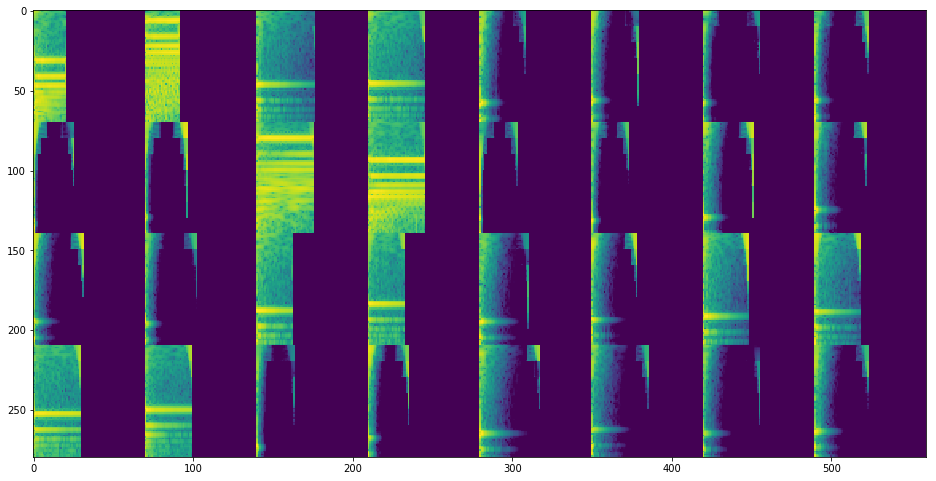

In [30]:
# Each pair of columns shows the (GT, pred) CQT spectrograms
plt.figure(figsize=(16,12))
plt.imshow(merge_images(inputs.numpy()[:16], pred_cqts[:16]))

In [31]:
for i in range(len(gt_samples)):
    print("GT")
    display(Audio(gt_samples[i], rate=2*gt_sampling_freqs[i]))
    print("Pred")
    display(Audio(pred_samples[i], rate=2*pred_sampling_freqs[i]))

GT


Pred


GT


Pred


GT


Pred


GT


Pred


GT


Pred


GT


Pred


GT


Pred


GT


Pred


GT


Pred


GT


Pred


GT


Pred


GT


Pred


GT


Pred


GT


Pred


GT


Pred


GT


Pred


GT


Pred


GT


Pred


GT


Pred


GT


Pred


GT


Pred


GT


Pred


GT


Pred


GT


Pred


GT


Pred


GT


Pred


GT


Pred


GT


Pred


GT


Pred


GT


Pred


GT


Pred


GT


Pred
